*Adınız*: Mert

Soyadınız:Gökce

Okul Numaranız:2212721057

GitHub Repo Bağlantısı: https://github.com/mertgokce07/CNN_siniflandirma

In [1]:
from google.colab import drive
drive.mount('/content/drive') #drive ı colab a bağlama.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
print(os.listdir("/content/drive")) #bağlantı kontrolü için drive içindeki ögeler listelenir.

['.shortcut-targets-by-id', 'MyDrive', '.Trash-0', '.Encrypted']


In [3]:
import os
print(os.listdir("/content/drive/MyDrive")) #bağlantı kontrolü için MyDrive içindeki ögeler listelenir.

['Colab Notebooks', 'Hafta2_EnergyStarScore.xlsx dosyasının kopyası.xlsx', 'Classroom', 'tablolar hatalı çıkmış ve uzatamamışsın.gsheet']


In [4]:
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/dataset"
print("DATA_DIR ayarlandı:", DATA_DIR) #Veri setinin drive daki konumu değişkene atanmıştır karmaşıklıkları önlemek için.

DATA_DIR ayarlandı: /content/drive/MyDrive/Colab Notebooks/dataset


In [5]:
import os

print(os.listdir(DATA_DIR))
print(os.listdir(DATA_DIR + "/ayakkabi")[:5])
print(os.listdir(DATA_DIR + "/bot")[:5])
#veri setinin ana dizini ve sınıf klasörleri kontrol edilmiştir.
#Ayakkabı ve bot sınıflarına ait örnek görüntü dosyaları listelenerek verilerin doğru şekilde yüklendiği doğrulanmıştır.ilk 5 görsel.

['ayakkabi', 'bot']
['IMG_1363.jpg', 'IMG_1367.jpg', 'IMG_1365.jpg', 'IMG_1364.jpg', 'IMG_1362.jpg']
['IMG_1562.jpg', 'IMG_1558.jpg', 'IMG_1559.jpg', 'IMG_1561.jpg', 'IMG_1560.jpg']


In [6]:
import tensorflow as tf # TensorFlow ve Keras fonksiyonlarını kullanabilmek için gerekli.

IMG_SIZE = (128, 128) #tüm görseller 128*128 px olur
BATCH_SIZE = 16 # Model her adımda 16 görsel ile eğitilir.GPU belleği yük, düşürerek süre uzar ama daha iyi genelleme.
SEED = 42 # Rastgelelik sabitlenir. örneğin başlangıçtaki ağırlıkları ve desteyi karıştırma rastgele başlar bunu hep aynı rastgelelikte tutmak için değerdir.
          # Seed olmasaydı batch_size daki bir değişikliğin performans üzerindeki etkisini gerçekten tam tespit edemezdik belki de başlangıç ağırlıkları kötü denk geldi.

full_ds = tf.keras.utils.image_dataset_from_directory( # Görselleri klasörden dataset olarak yükleme. DATA_DIR içindeki klasör adlarına göre otomatik label oluşturur.
    DATA_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True, #görseller her epoch öncesi karıştırır.
    seed=SEED
)

class_names = full_ds.class_names # full.ds içindeki Sınıf ismimlerini alır. class_names[0] hangi sınıfsa label 0 odur.
NUM_CLASSES = len(class_names) # Sınıf sayısını alır. Bizde 2

ds_size = full_ds.cardinality().numpy() # Veri setinin boyutunu(batch) hesaplıyoruz 306/16 =~ 19 batch sayısı
test_size = int(ds_size * 0.15) # Veri setinin %15 i test için  --- int kullanıyoruz çünkü: batch tam sayı olmalı
val_size  = int(ds_size * 0.15) # Veri setinin %15 i validation için
train_size = ds_size - test_size - val_size # Kalan %70 de train için

# full.ds tüm veriyi içeren küme
train_ds = full_ds.take(train_size) # full_ds veri kümesinin başından itibaren tam olarak train_size kadar veri örneğini alır ve bunu train_ds (Eğitim Kümesi) olarak adlandırır.
temp_ds  = full_ds.skip(train_size) # full_ds veri kümesinin başından itibaren train_size kadar örneği atla demektir. Yani eğitim kümesi harici veriler temp.ds e atanır(val ve test için)
val_ds   = temp_ds.take(val_size) # temp_ds kümesinin (yani eğitimin dışında kalan verinin) başından itibaren val_size kadar veri örneğini alır.
test_ds  = temp_ds.skip(val_size) # temp_ds kümesinin (doğrulama ve testin birleşimi) başından itibaren val_size kadar örneği atla demektir.Yani geriye kalan tüm veriler test_ds (Test Kümesi) olur.

AUTOTUNE = tf.data.AUTOTUNE # kaynaklar göz önüne alınarak, en verimli paralel işleme sayısını (kaç tane verinin aynı anda hazırlanacağı) otomatik olarak hesaplama yetkisi verir.
train_ds = train_ds.cache().shuffle(200).prefetch(AUTOTUNE) # Veri kümesi ilk defa yüklendikten veya işlendikten sonra, sonuçları belleğe (RAM) veya yerel diske kaydeder.sonraki tüm epoch'larda (eğitim döngülerinde) model diske geri dönmek yerine, çok daha hızlı olan bellekten okuma yapar.
val_ds   = val_ds.cache().prefetch(AUTOTUNE) # her seferinde 200 örnek arasından rastgele bir örnek seçilir.
test_ds  = test_ds.cache().prefetch(AUTOTUNE) # Model GPU'da eğitilirken, CPU aynı anda bir sonraki veri topluluğunu hazırlar.

print("Sınıflar:", class_names)
print("Train / Val / Test:", train_size, val_size, test_size)


Found 306 files belonging to 2 classes.
Sınıflar: ['ayakkabi', 'bot']
Train / Val / Test: 14 3 3


In [7]:
from tensorflow.keras import layers # Veri artırma sadece test için

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"), # rastgele olarak yatay eksende (soldan sağa) çevirir.
    layers.RandomRotation(0.1), # Görüntüleri rastgele olarak +0.1 radyan (yaklaşık 5.7 derece) ile -0.1 radyan arasında döndürür.
    layers.RandomZoom(0.1), # Görüntüleri rastgele olarak %10 oranına kadar yakınlaştırır veya uzaklaştırır.
    layers.RandomContrast(0.1), # Görüntülerin kontrastını rastgele olarak %10 oranında değiştirir.
])


In [8]:
from tensorflow.keras.applications import ResNet50 #Önceden Eğitilmiş Model (ResNet50)
from tensorflow.keras import models

base_model = ResNet50(
    weights="imagenet", #ağırlıklarının devasa ImageNet veri kümesi üzerinde yapılan eğitimden gelmesini sağlar.
    include_top=False, #ImageNet sınıfını tahmin eden son katmanı (classification head) hariç tutar.
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3) # Modelinize girecek görüntülerin boyutunu (IMG_SIZE) ve 3 renk kanalını (RGB) tanımlar.
)

base_model.trainable = False  # 1. aşama: donduruldu. base_model içindeki tüm ağırlıkların dondurulmasını sağlar. Bu Transfer Learning'in ilk aşamasıdır.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Ön işleme
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs) # Görüntü girişi, daha önce tanımladığınız Veri Artırma katmanlarından geçer (rastgele döndürme, çevirme vb.)
x = tf.keras.applications.resnet.preprocess_input(x) # ResNet50'nin, ImageNet üzerinde eğitilirken kullandığı özel ön işleme adımlarını (genellikle renk kanalı ortalamasını çıkarma) uygular.

x = base_model(x, training=False) #Giriş verisini, daha önce dondurduğunuz (trainable=False) ResNet50 modeline gönderir.
x = layers.GlobalAveragePooling2D()(x) # ResNet50'den çıkan özellik haritalarının (feature maps) boyutunu tek bir vektöre indirir.
x = layers.Dropout(0.3)(x) # overfitting) engellemek için, rastgele olarak nöronların %30'unu bir eğitim adımında kapatır. Bu, modelin tek bir nörona aşırı güvenmesini engeller.
outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x) # özel görev için oluşturulmuş yeni ve eğitilebilir son katmandır (Classification Head). activation="softmax": Çıktıları her bir sınıf için olasılık dağılımına dönüştürür (tüm olasılıkların toplamı 1'dir).

model = models.Model(inputs, outputs) #Girişleri ve çıkışları tanımlayarak modeli resmi olarak oluşturur.
model.summary() # Modelin katmanlarını, çıktı şekillerini ve en önemlisi eğitilebilir ve eğitilemez parametre sayısını gösteren bir tablo yazdırır.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 128, 128)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 128, 128)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 128, 128)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 128, 128,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2)         │      4,098 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Hata Hesaplama: Tahmin ile gerçek değer arasındaki hatayı sparse_categorical_crossentropy kullanarak hesapla.

Ağırlık Güncelleme: Bu hatayı azaltmak için Adam algoritmasını kullanarak ağırlıkları $0.001$ hızında değiştir.

İzleme: Tüm bu süreç boyunca doğru tahmin oranını (accuracy) sürekli olarak izle ve kaydet.

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping( # Modelin, Doğrulama kümesi üzerindeki performansının (val_accuracy) belirli bir süre (sabır süresi) boyunca artmadığını fark ederse, eğitimi otomatik olarak durdurur.
        monitor="val_accuracy", # Gözlemlenecek metrik, doğrulama kümesi üzerindeki doğruluktur.
        patience=5, # Doğruluk art arda 5 epoch boyunca iyileşmezse (veya durursa), eğitim durdurulur.
        restore_best_weights=True # Eğitim durdurulduktan sonra, modelin ağırlıkları en iyi doğruluk değerine ulaşılan epoch'taki haline geri yüklenir.
    ),
    tf.keras.callbacks.ReduceLROnPlateau( # Model, Doğrulama kümesi üzerindeki kaybının (val_loss) belirli bir süre iyileşmediğini fark ederse, öğrenme oranını (Learning Rate) otomatik olarak düşürür. küçük adımlar
        monitor="val_loss", # Gözlemlenecek metrik, doğrulama kaybıdır.
        factor=0.5, # yeni öğrenme oranı, eski oranın yarısı olarak ayarlanır.
        patience=2 # Doğrulama kaybı art arda 2 epoch boyunca iyileşmezse (plato çizerse), öğrenme oranı değiştirilir.
    )
]

history_1 = model.fit( # Model eğitimi
    train_ds,
    validation_data=val_ds,
    epochs=20, # Max epoch sayısı
    callbacks=callbacks
)



Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.5816 - loss: 1.2079 - val_accuracy: 0.7500 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7527 - loss: 0.6285 - val_accuracy: 0.7708 - val_loss: 0.5455 - learning_rate: 0.0010
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8821 - loss: 0.2568 - val_accuracy: 0.8958 - val_loss: 0.2687 - learning_rate: 0.0010
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.8813 - loss: 0.3101 - val_accuracy: 0.8750 - val_loss: 0.2584 - learning_rate: 0.0010
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.9458 - loss: 0.1601 - val_accuracy: 0.8750 - val_loss: 0.2332 - learning_rate: 0.0010
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9198 - loss: 0.3017 - val_accuracy: 0.9375 - val_loss: 0.1679 - learning_rate: 0.0010
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.8744 - loss: 0.3443 - val_accuracy: 

Alttaki kod parçacığı, İnce Ayar (Fine-Tuning) adı verilen Transfer Öğrenme stratejisinin ikinci ve daha gelişmiş aşamasını başlatıyor.

Daha önceki adımda (base_model.trainable = False ile), ResNet50'nin tüm ağırlıklarını dondurmuştuk. Şimdi ise bu dondurma işlemini kısmen kaldırıyoruz.

In [12]:
# Base modeli açıyoruz tüm katmanlar artık eğitilebilir.
base_model.trainable = True

for layer in base_model.layers[:-30]: # Son 30 katmana kadarki kısmı seç
    layer.trainable = False # Seçili kısmın eğitilebilirliğini dondur. Yani son 30 katman açık şuan
    # Giriş katmanına yakın olan ilk katmanlar dondurulur çünkü o katmanlarda temel özellikler öğrenilir.çizgiler, kenarlar, renkler, dokular
    # ImageNet'ten gelen bilgiyi bizim veri kümemize en uygun olacak şekilde ince ayar yapmasını sağladık.

In [13]:
# öğrenme oranını baya düşürdük çok küçük adımlarla gitsin ince ayar yapıyoruz
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [14]:
# Yaptığımız son ince ayarları uyguluyoruz.
history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=callbacks
)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8542 - loss: 0.3499 - val_accuracy: 0.9792 - val_loss: 0.0926 - learning_rate: 1.0000e-05
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8414 - loss: 0.3070 - val_accuracy: 0.9792 - val_loss: 0.0744 - learning_rate: 1.0000e-05
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9167 - loss: 0.1989 - val_accuracy: 0.9792 - val_loss: 0.0585 - learning_rate: 1.0000e-05
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.9451 - loss: 0.1330 - val_accuracy: 0.9792 - val_loss: 0.0486 - learning_rate: 1.0000e-05
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9714 - loss: 0.1131 - val_accuracy: 0.9792 - val_loss: 0.0371 - learning_rate: 1.0000e-05
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9392 - loss: 0.1241 - val_accuracy: 0.9792 - val_loss: 0.0321 - learning_rate: 1.0000e-05


**Mavi Çizgi (Train Accuracy):** Eğitim kümesindeki modelin başarısı. Bu çizgi genellikle sürekli artar.

**Turuncu Çizgi (Validation Accuracy):** Doğrulama kümesindeki modelin başarısı. Modelin genelleme yeteneğini gösterir.

**Analiz:** Bu grafikte aradığımız şey, iki çizginin mümkün olduğunca yakın ilerlemesi ve Doğrulama Doğruluğu'nun modelin sonlandığı noktada en yüksek değerine ulaşmasıdır. İki çizgi arasındaki büyük bir fark, aşırı uyum (overfitting) olduğunu gösterir.

**Mavi Çizgi (Train Loss):** Eğitim kümesindeki modelin hata oranı.

**Turuncu Çizgi (Validation Loss):** Doğrulama kümesindeki modelin hata oranı.

**Analiz:** Her iki çizginin de düşmesi istenir. Ancak, Doğrulama Kaybı düşmeyi durdurup tekrar yükselmeye başlarsa, bu overfitting'in başladığı ve EarlyStopping'in doğru zamanda devreye girmesi gerektiği anlamına gelir.

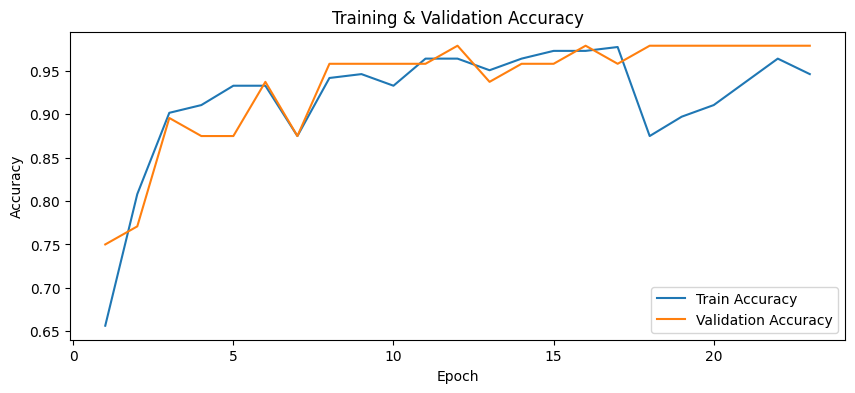

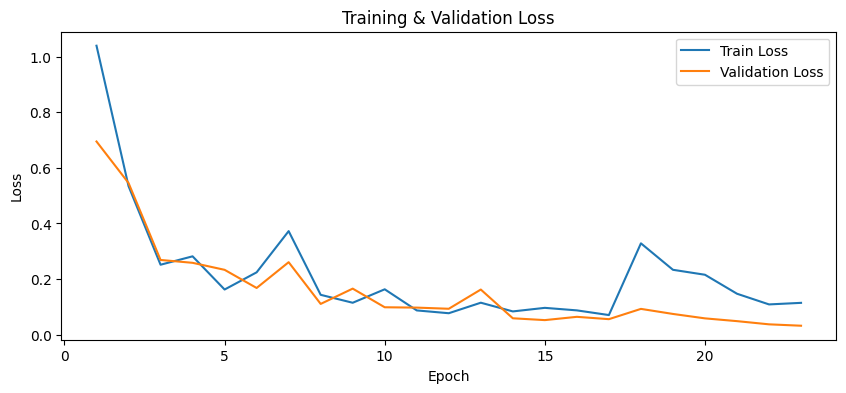

In [15]:
# Bu kod, iki aşamalı eğitimin bütünleşik sonuçlarını görselleştirerek, modelinizin ne zaman en iyi genelleme performansına ulaştığını net bir şekilde gösterir.
import matplotlib.pyplot as plt

def plot_history(h1, h2):
    acc = h1.history["accuracy"] + h2.history["accuracy"]
    val_acc = h1.history["val_accuracy"] + h2.history["val_accuracy"]
    loss = h1.history["loss"] + h2.history["loss"]
    val_loss = h1.history["val_loss"] + h2.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.figure(figsize=(10,4))
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")
    plt.show()

    # Loss
    plt.figure(figsize=(10,4))
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    plt.show()

plot_history(history_1, history_2)


In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
# En sonki nihai başarı oranı hiç görmediği verilerle (test_ds)


3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - accuracy: 1.0000 - loss: 0.0114
Test Loss: 0.011049644090235233
Test Accuracy: 1.0


In [17]:
model.save("/content/drive/MyDrive/Colab Notebooks/model1.keras")
print("Model1 kaydedildi")


Model1 kaydedildi


### 📷 Tek Görsel ile Tahmin
Aşağıdan bir ayakkabı veya bot fotoğrafı yükleyerek modelin tahminini görebilirsiniz.


In [29]:
from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()


Saving download (1).jpg to download (1).jpg


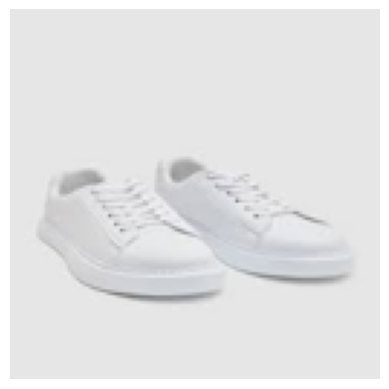

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
ayakkabi: %97.52
bot: %2.48

🟢 Tahmin: AYAKKABI (%97.52)


In [30]:
# Yüklenen dosya adını al
img_path = list(uploaded.keys())[0]

# Görseli aç
img = Image.open(img_path).convert("RGB")
img = img.resize((128, 128))

# Görselleştir
plt.imshow(img)
plt.axis("off")
plt.show()

# Modele uygun hale getir
from tensorflow.keras.applications.resnet import preprocess_input

img_array = np.array(img)
img_array = preprocess_input(img_array)
img_array = np.expand_dims(img_array, axis=0)


# Tahmin
pred = model.predict(img_array)[0]

# Sınıf isimleri
class_names = ["ayakkabi", "bot"]

# Yüzdeli sonuç
for i, cls in enumerate(class_names):
    print(f"{cls}: %{pred[i]*100:.2f}")

# En yüksek olasılık
predicted_class = class_names[np.argmax(pred)]
confidence = np.max(pred) * 100

print(f"\n🟢 Tahmin: {predicted_class.upper()} (%{confidence:.2f})")
